<center> <h1> Weekly Time Commitment Stress Tester </h1> </center>

This is kind of an overkill for something that can be simply done through the use of some simple back of the napkin calculations, but I had some time and felt like coding out a Monte Carlo Simulation fort he first time(I have done some on excel spreadsheets but not in python). This is meant to be reused and adapted for various needs and times when you need to make sure you aren't overextending yourself.

## Motivation

As an incoming student at Columbia University, and geek, I have a tendency to be interested in doing and pursuing too many things(My first two years at Colby College is a testament to this), so to prevent this sort of situation from happening again, I wanted to create this simple script where i can input different things I am interested in along with a range of time that I plan on working(which would come in the form of an upper bound. lower bound, and most likely). This would then allow me to use the law of large numbers to get a sense of what type of activities I can take on. However, I must come up with good assumptions since that will be the driving force of the simulation of the semester.(Remember:Garbage in Garbage Out)


### The simulation will run below the initial code needed to set it up and can be found below

This is also where you can input the csv file that you want the program to read


In [1]:
#need to import some data science packages
import random as rand
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm # We will be using the ppf function to do the simulations
%matplotlib inline 
#This is to make sure the graphs print out in line

## Activity Classes

This class will hold all the information, run the simulation , as well as return back the information we need to visualize the results and reach our conclusions



In [2]:
class Activity:
    #some attributes we want the class to hold
    average=0.0
    stdev=0.0
    weekhrs=[]#this list will hold the results on a per week basis
    activityName=""#This will hold the activity's name for future reference
    
    
    def __init__(self,lowerBound,mostLikely,upperBound,activityName):
        #Initialize with three inputs and then calculate the rest
        
        #This is the base formula used when doing a three point simulation like being done here, but this 
        #can be changed to skew the output of the inverse normal cdf
        self.average=(lowerBound+4*mostLikely+upperBound)/6.0 #6.0 since we want to make the average a float
        self.stdev=(upperBound-lowerBound)/6.0
        
        self.activityName=activityName#Set the activity's name as a string
        
        
    #Create a method that will simulate the next week
    def oneWeekStep(self):
        step=rand.normalvariate(self.average,self.stdev)
        self.weekhrs.append(step)#We will need to use a seed based on the time module                                                   #to ensure we are getting trully random results
        return step
    
    #getter for the weekhrs list
    def getWeekhrs(self):
        return self.weekhrs
    
    #Create a string function
    def __str__(self):
        return str(self.activityName)
        
#Test the class functions primary methods      
# ac=Activity(5,10,20,"test")
# ac.oneWeekStep()
# ac.oneWeekStep()
# print(ac.oneWeekStep())
# print(ac.getWeekhrs())
# print(ac)
    
        

## Input the General Data

We will define a method below that will accept all the data points we need such as number of weeks, number of hours per week you can dedicate to activities(to exclude sleeping, eating, and other things), and other things like that. 


### Parameters
For all of these parameters please enter them in decimal format
- sleepHours:This is the number of hours you want to sleep per day
- groomHours:This is the number of hours you spend grooming(Shower,Brushing teeth, etc.) per day
- eatHours:This is the number of hours you spend eating food per day
- errandHours:This is supposed to count the number of hours you spend during errands per week
- commuteHours:This is how much time you spend commuting per day
- funHours:This is a measure per week of how much time you want to give yourself per week
- otherHours:This is a catchall to make sure nothing is missed and is measured on a per week basis
- numSim:This represents the number of weeks you want to include in your simulation(Generally,the Larger the number the better)

Make sure the output of this cell makes sense to you!



In [3]:
#############################
#Input your preferences here#
########Hours per Day########
sleepHours=8
groomHours=1.25
eatHours=1.5
commuteHours=0.0
############################
#######Hours per week#######
errandHours=2
funHours=10
otherHours=6.25
#############################
#############Other###########
numSim=1000000
#############################
hoursPerWeek=7*24
#Create a list of the above variables
hourLimits=((sleepHours+groomHours+eatHours+commuteHours)*7)+errandHours+funHours+otherHours
percentWeek=hourLimits/hoursPerWeek *100
print("You are currently allocating {} hours to non activities which is {}% of your total hours per week".format(hourLimits
                                                                                                                ,percentWeek))
print("\n")
print("This leaves you with {} hours for activities".format(hoursPerWeek-hourLimits))

You are currently allocating 93.5 hours to non activities which is 55.654761904761905% of your total hours per week


This leaves you with 74.5 hours for activities


## Input Activity Specific Data

We will now input have a place to input the activity specific data from a csv file into the class we have built above. To enter this data correctly please enter the name of the csv file that contains the data for each of your activities in the following format.
Note: Make sure the csv file is in the same directory as the jupyter notebook. If not include a the whole address to the file. 

| Activity Name | Lower Bound Hours Per Week | Most Likely Hours Per Week | Upper Bound Hours Per Week |
|---------------|----------------------------|----------------------------|----------------------------|
| Activity 1    | 2                          | 5                          | 8                          |
| Activity 2    | 2                          | 5                          | 8                          |
| ...           | ...                        | ...                        | ...                        |

### After Entering the data click run all under the Kernel Tab


In [4]:
#########################################
########Input CSV in a list here#########
csvList=["Fall2020.csv"]
#########################################
data=[]
for csv in csvList:
    dataframe=pd.read_csv(csv)
    data.append(dataframe)


# Simulation Class
Now we need to run the simulation for the number of weeks you have specified. For this we can create a class that will make it much easier to be able to run simulations with different the activity combinations you have entered above.

In [5]:
class Simulation:
    activities=[] #holds a list of activities
    numSim=0#this will hold the number of simulations we want to run(of the whole semester)
    hoursPerWeek=7*24 #7 days times 24 hours
    nonActivityHours=0.0#this will hold nonactivity hours
    results=[]#This will be a 2D array that will hold results of multiple semester simulations
    
    #Create a constructor method
    def __init__(self,nonactivityHours,numSim,activities):
        self.nonActivityHours=nonactivityHours
        self.numSim=numSim
        self.activities=activities
    
    def simulate(self):
        for week in range(1,self.numSim):
            rand.seed(time.time())
            #we need to call each of the activities and have them take one step
            total=0
            for ac in self.activities:
                week=ac.oneWeekStep()
                total += week
                #now we will sum the results of all the activities per week
            self.results.append(total+self.nonActivityHours)
    def graph(self):
        #this method will graph a histogram and show the point where the number of hours is above the limit of 168
        print("This is for the Simulation with {}".format(self.toString()))
        print(self.percentAbove())
        plt.figure(figsize=[15,8])
        sns.distplot(self.results,kde=False)
        plt.ylabel("Frequency")
        plt.xlabel("Hours Per Week")
        plt.axvline(hoursPerWeek,color='red')
    
    #Create an str method that will print out the activities in the simulation
    def toString(self):
        output="The activities in this Simulation are:"
        for ac in self.activities:
            output+=str(ac)+","
        return output
            
    #Create a function that will return text containing the percentage of time above the total number of hours
    def percentAbove(self):
        countAbove=0
        for x in self.results:
            if x > self.hoursPerWeek:
                countAbove+=1
        return "{}% of the weeks simulated were above {} hours per week".format(((countAbove/(len(self.results)+1)*100))
                                                                                ,self.hoursPerWeek)
    #Now for a cohesive method that simply outputs what we need
    def output(self):
        self.simulate()#We want to run the Simulation
        self.graph()


# Run the Simulation!
Here we will run the simulation and it will output histograms.

This is for the Simulation with The activities in this Simulation are:BME LAB 1,BME 1,Quant Phys,Intro EE,Biostat,FSAE,CSI,CUCyber,Research,Instrument,Job,Internship Search,
24.288999999999998% of the weeks simulated were above 168 hours per week


C:\Users\adish\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


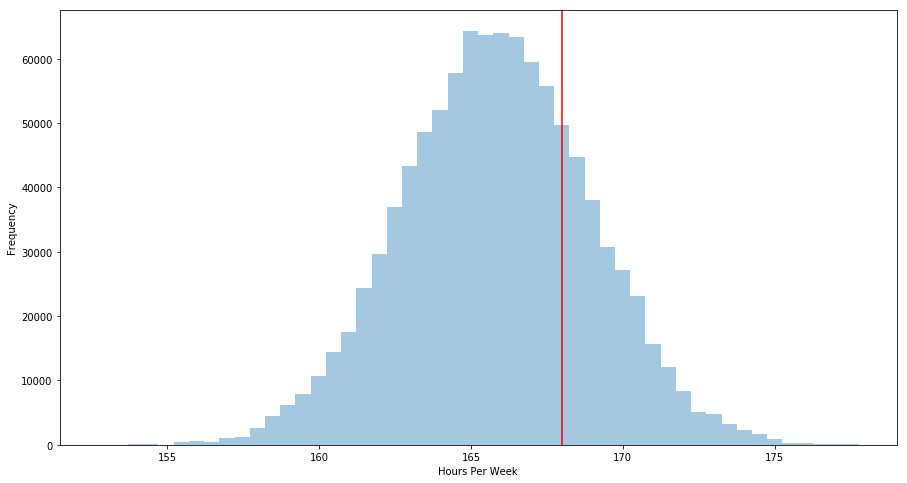

In [6]:
for df in data:
    #We will call each of these dataframes into a simulation class and then run all of the simulations
    activities=[]
    for index,row in df.iterrows():
        activities.append(Activity(row["Lower Bound Hours Per Week"],row["Most Likely Hours Per Week"],
                          row["Upper Bound Hours Per Week"],row["Activity Name"]))
    sim=Simulation(hourLimits,numSim,activities)
    sim.output()
    print("\n")


# Done!
Now you can take a look at what this means. The line above the graph give you the percentage of the weeks simulated that went above the total number of hours in a week:168. This limit is shown the graph using the red line. All of the blue mass to the left of the limit represents the number of weeks that are within the limit. You can use this histogram to to make decisions on what you should end up doing. Feel free to use the feature where you can enter in different combinations for CSV and see what happens to your graphs. Also, make sure you are making reasonable assumptions before running the simulation and understand the context that those assumptions put the results of the simulation under. Remember "Garbage in Garbage Out"

In my case, I think the assumptions I have made are the worst case scenario and therefore having a distribution that looks like the one I have above would actually work well